In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'

gender = 'female'

output_dir = f'/Users/jkember/Documents/nia_health/NHANES/biological_age/data/output_{gender}/'

data = pd.read_csv(f'{output_dir}/data_imputed.csv')
deltas = pd.read_csv(f'{output_dir}/biomarker_delta_ages.csv')
weights = pd.read_csv(f'{output_dir}/model_weights.csv', index_col=0)


contributions = weights.to_dict()['weight'] * deltas
delta_age = contributions.sum(axis=1)
bio_age = data['age'] + delta_age



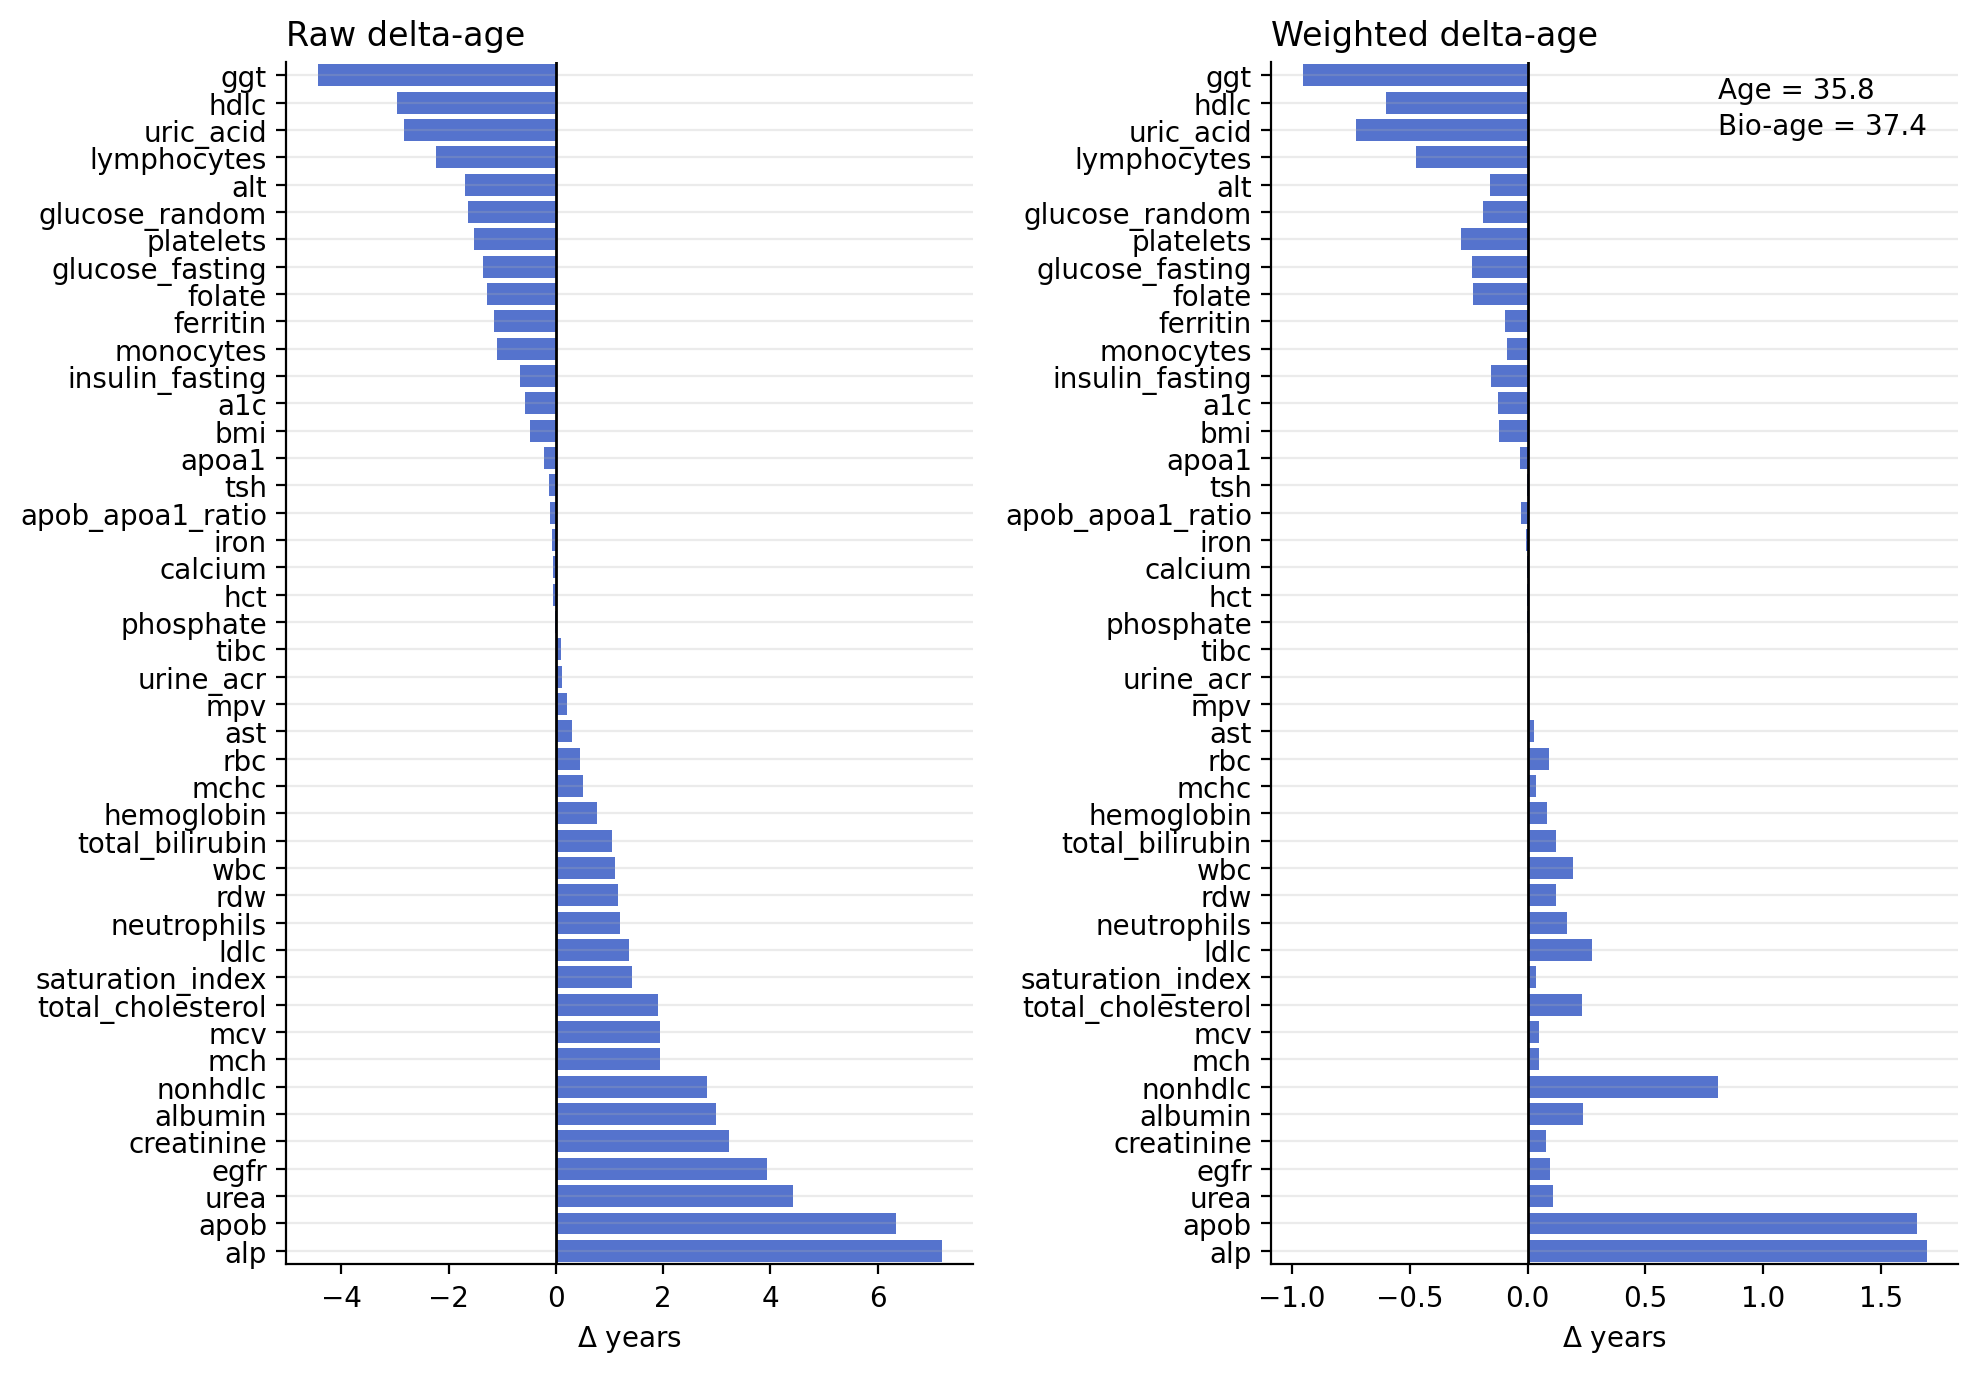

In [828]:
user_idx = 0

user_age = data.iloc[user_idx,:]['age']
user_data = data.iloc[user_idx,:]
user_deltas = deltas.iloc[user_idx,:]
user_contributions = contributions.iloc[user_idx,:]
user_bio_age = user_age + user_contributions.sum()


feature_order = user_deltas.sort_values().index
user_data = user_data[feature_order]
user_deltas = user_deltas[feature_order]
user_contributions = user_contributions[feature_order]


fig, ax = plt.subplots(1,2,figsize=(10,7))

sns.barplot(user_deltas, ax=ax[0], orient='h', color='royalblue')
sns.despine()
ax[0].set_title('Raw delta-age', loc='left')
ax[0].set_xlabel('$\Delta$ years')
ax[0].axvline(0, color='k', lw=1)
ax[0].grid(axis='y', alpha=.25)

sns.barplot(user_contributions, ax=ax[1], orient='h', color='royalblue')
sns.despine()
ax[1].set_title('Weighted delta-age', loc='left')
ax[1].set_xlabel('$\Delta$ years')
ax[1].axvline(0, color='k', lw=1)
ax[1].grid(axis='y', alpha=.25)

plt.tight_layout()



ax[1].text(.65,.97,f'Age = {user_age:.1f}', transform=ax[1].transAxes)
ax[1].text(.65,.94,f'Bio-age = {user_bio_age:.1f}', transform=ax[1].transAxes)

plt.show()


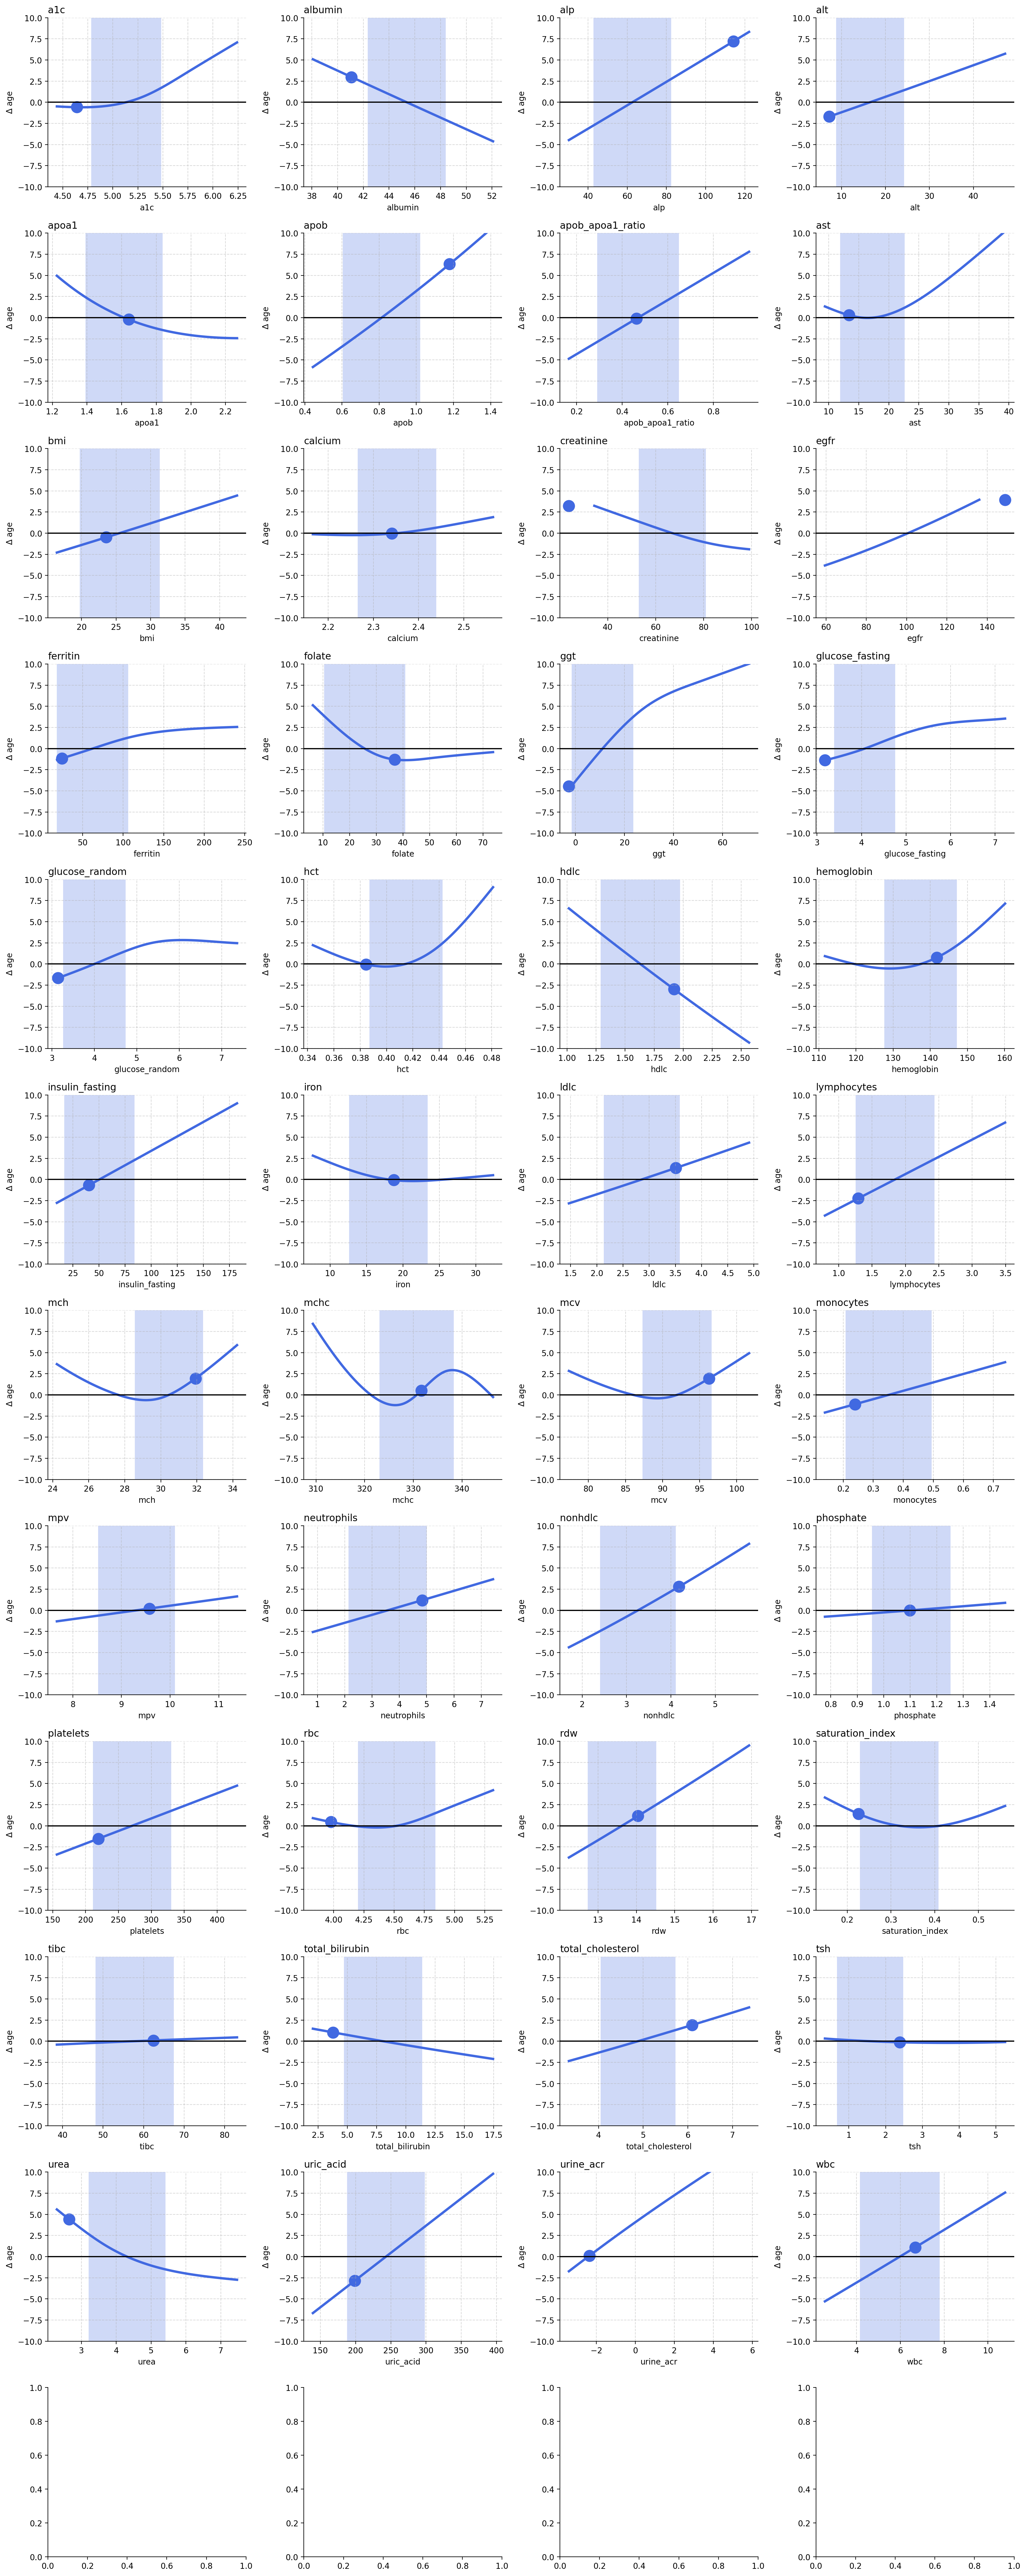

In [829]:


fig, ax = plt.subplots(12,4, figsize=(18,45))
ax = ax.flatten()

user_data = user_data.sort_index()
for idx, feature in enumerate(user_data.index):

    delta_age_grid = pd.read_csv(f'{output_dir}/{feature}/model/delta_age-array.csv', index_col=0)
    feature_vals = delta_age_grid.index
    feature_vals = np.linspace(feature_vals.min(), feature_vals.max(), len(feature_vals))
    age_vals = delta_age_grid.columns.astype(float)

    ref_idx = np.argmin(np.abs(user_age - age_vals))

    ax[idx].plot(feature_vals, delta_age_grid.iloc[:,ref_idx].values, lw=3, color='royalblue')
    ax[idx].axhline(0, linestyle='-', color='k')
    ax[idx].set_xlabel(feature)
    ax[idx].set_ylabel('$\Delta$ age')
    ax[idx].grid(linestyle='--', alpha=.5)

    try:
        expected_vals = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_values-vector.csv', index_col=0)
        expected_SDs = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_SD-vector.csv', index_col=0)

        user_expected_val = expected_vals.iloc[ref_idx].item()
        user_expected_sd = expected_SDs.iloc[ref_idx].item()

        ax[idx].axvspan(
            user_expected_val-user_expected_sd,
            user_expected_val+user_expected_sd,
            alpha=.25, facecolor='royalblue'
        )
    except: None

    ax[idx].scatter(user_data[feature], user_deltas[feature], s=200, color='royalblue')
    ax[idx].set_title(feature, loc='left')
    ax[idx].set_ylim([-10,10])
    sns.despine()

plt.tight_layout()
plt.show()

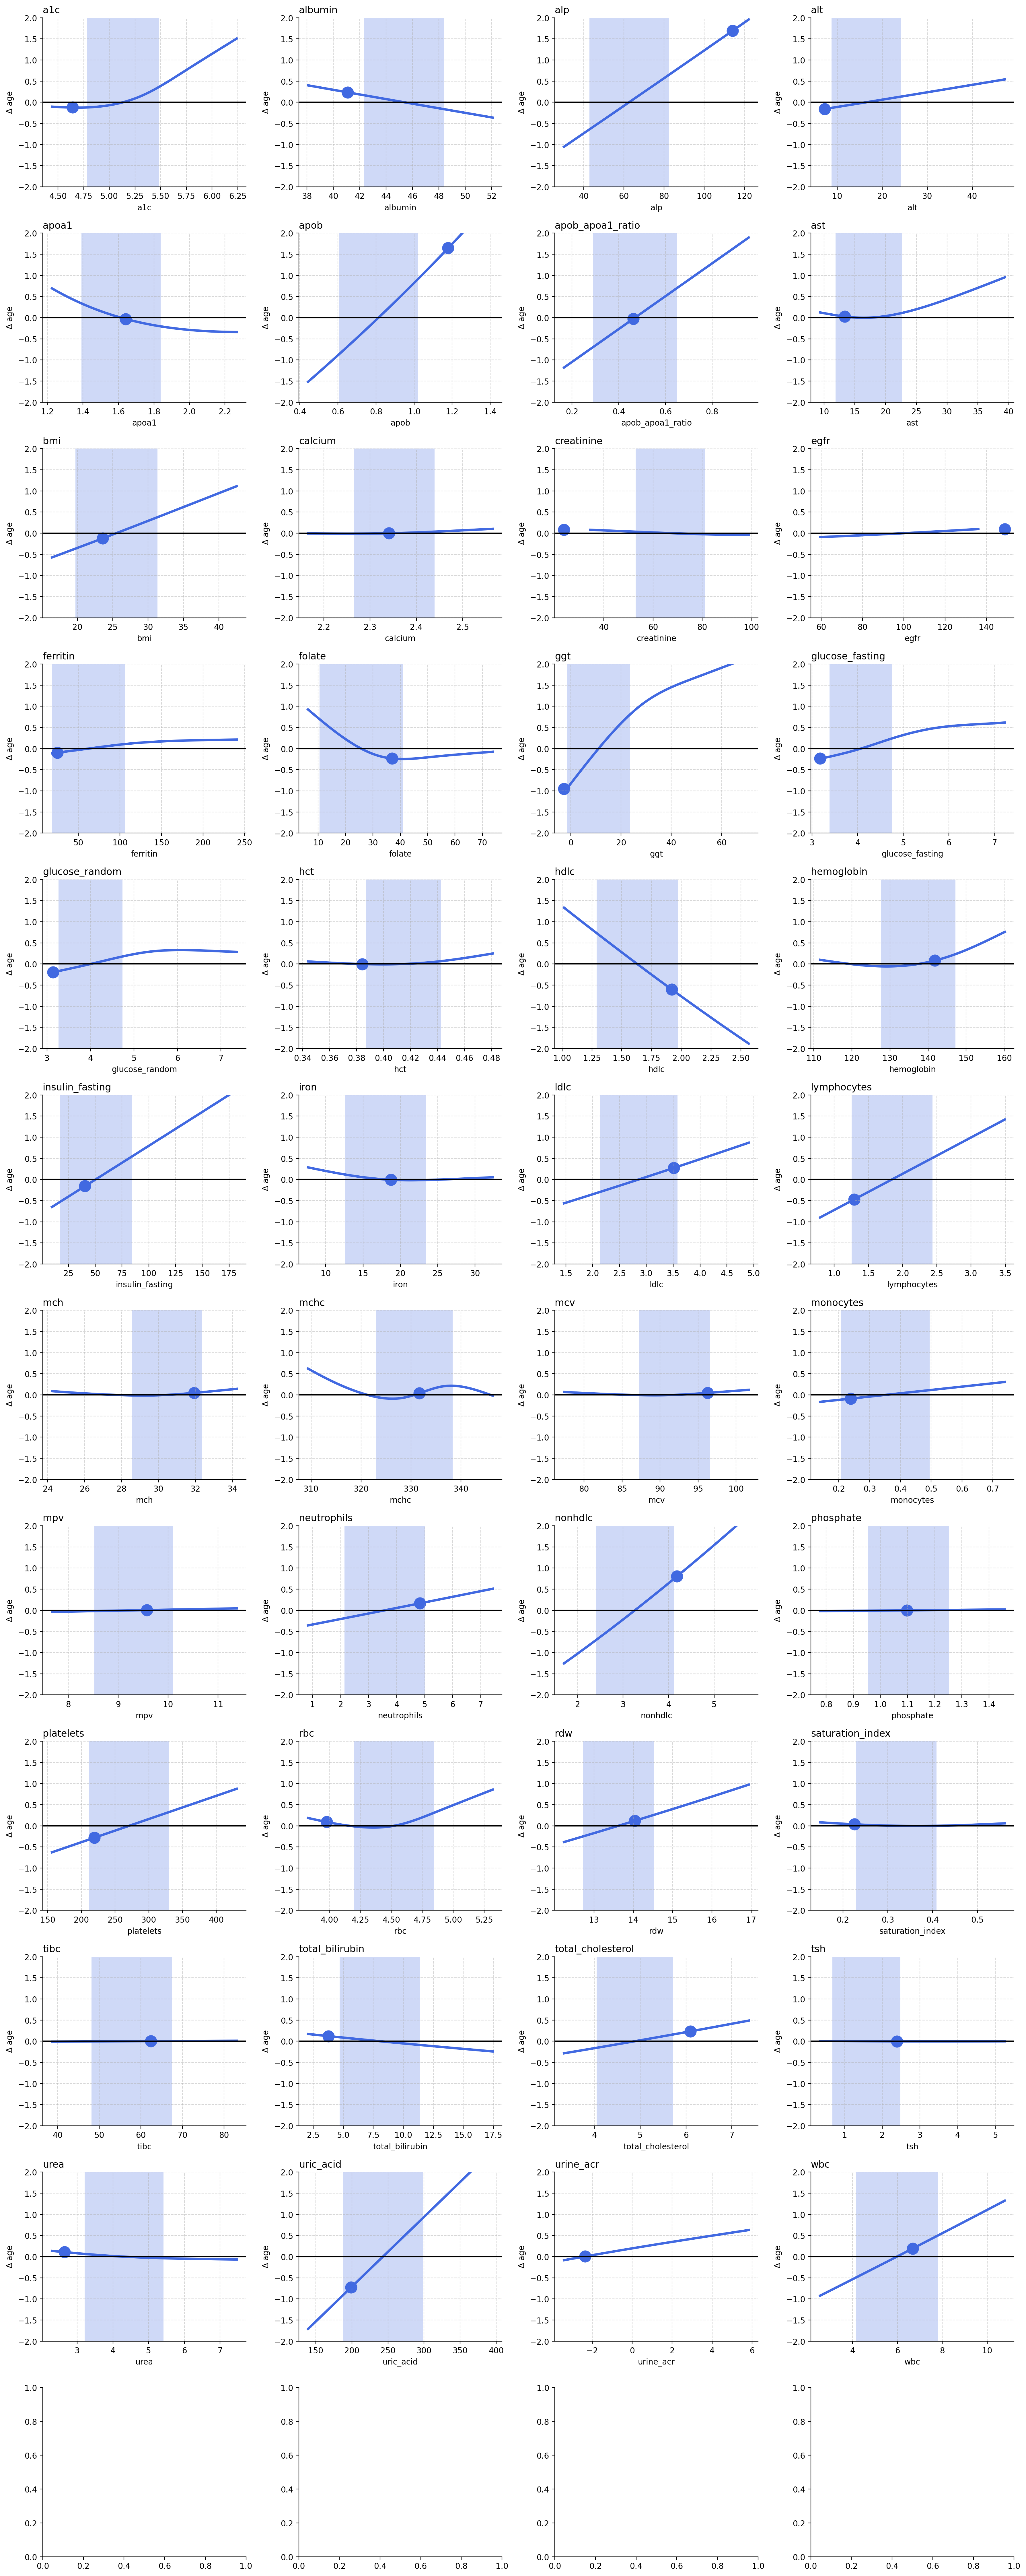

In [830]:

weights = pd.read_csv(f'{output_dir}/model_weights.csv', index_col=0)

fig, ax = plt.subplots(12,4, figsize=(18,45))
ax = ax.flatten()

user_data = user_data.sort_index()
for idx, feature in enumerate(user_data.index):

    delta_age_grid = pd.read_csv(f'{output_dir}/{feature}/model/delta_age-array.csv', index_col=0)
    delta_age_grid = delta_age_grid * weights.loc[feature].item()

    feature_vals = delta_age_grid.index
    feature_vals = np.linspace(feature_vals.min(), feature_vals.max(), len(feature_vals))
    age_vals = delta_age_grid.columns.astype(float)

    ref_idx = np.argmin(np.abs(user_age - age_vals))


    # fig, ax = plt.subplots(figsize=(5.5,4))
    ax[idx].plot(feature_vals, delta_age_grid.iloc[:,ref_idx].values, lw=3, color='royalblue')
    ax[idx].axhline(0, linestyle='-', color='k')
    ax[idx].set_xlabel(feature)
    ax[idx].set_ylabel('$\Delta$ age')
    ax[idx].grid(linestyle='--', alpha=.5)

    try:
        expected_vals = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_values-vector.csv', index_col=0)
        expected_SDs = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_SD-vector.csv', index_col=0)

        user_expected_val = expected_vals.iloc[ref_idx].item()
        user_expected_sd = expected_SDs.iloc[ref_idx].item()

        ax[idx].axvspan(
            user_expected_val-user_expected_sd,
            user_expected_val+user_expected_sd,
            alpha=.25, facecolor='royalblue'
        )
    except: None

    ax[idx].scatter(user_data[feature], user_deltas[feature]* weights.loc[feature].item(), s=200, color='royalblue')
    ax[idx].set_title(feature, loc='left')
    ax[idx].set_ylim([-2,2])
    sns.despine()

plt.tight_layout()
plt.show()



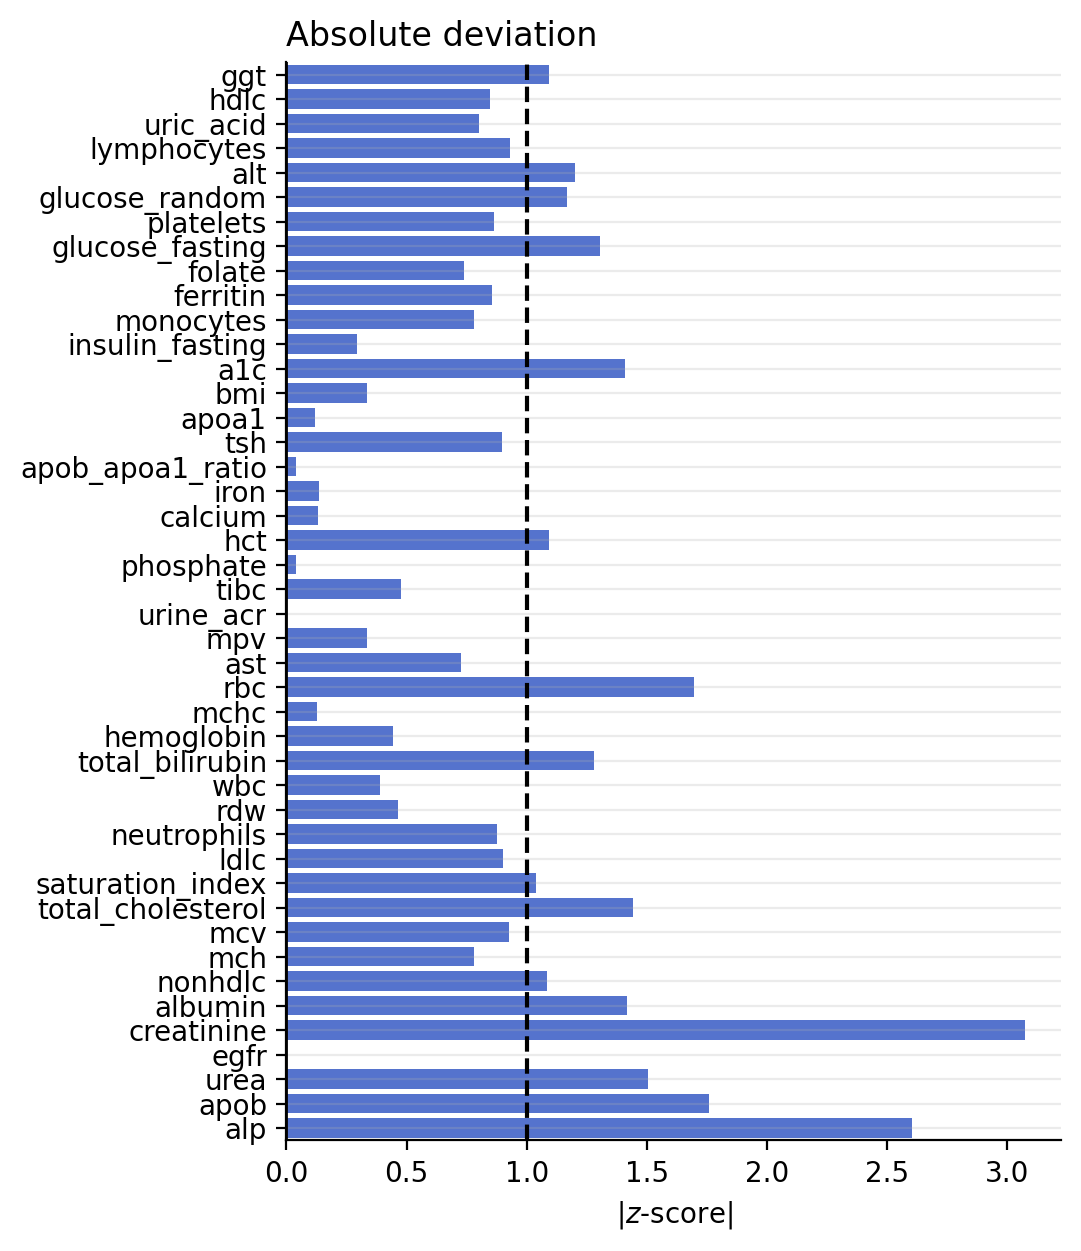

In [831]:
deviations = {}
for feature in user_data.index:
    try: 
        expected_vals = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_values-vector.csv', index_col=0)
        expected_SDs = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_SD-vector.csv', index_col=0)

        user_expected_val = expected_vals.iloc[ref_idx].item()
        user_expected_sd = expected_SDs.iloc[ref_idx].item()

        deviations[feature] = (user_data.loc[feature] - user_expected_val) / user_expected_sd
    except:
        deviations[feature] = np.nan

deviations = pd.Series(deviations)

fig, ax = plt.subplots(figsize=(5,7))

sns.barplot(deviations[feature_order].abs(), ax=ax, orient='h', color='royalblue')
sns.despine()
ax.set_title('Absolute deviation', loc='left')
ax.set_xlabel('|$z$-score|')
ax.axvline(0, color='k', lw=1)
ax.grid(axis='y', alpha=.25)
ax.axvline(1, linestyle='--', color='k')


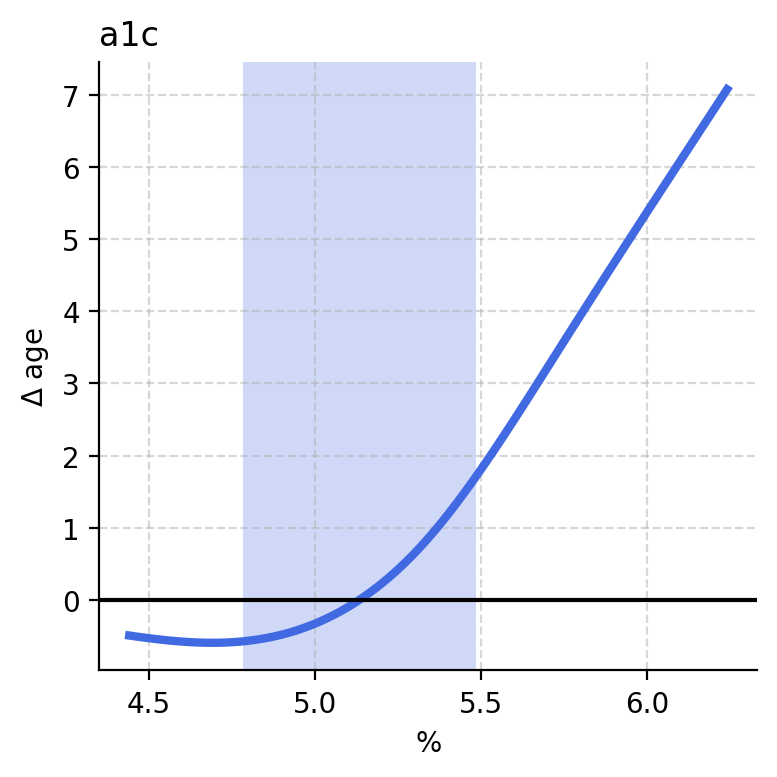

In [832]:
feature = 'a1c'

delta_age_grid = pd.read_csv(f'{output_dir}/{feature}/model/delta_age-array.csv', index_col=0)

feature_vals = delta_age_grid.index
feature_vals = np.linspace(feature_vals.min(), feature_vals.max(), len(feature_vals))
age_vals = delta_age_grid.columns.astype(float)

ref_idx = np.argmin(np.abs(user_age - age_vals))


fig, ax = plt.subplots(figsize=(4,4))

ax.plot(feature_vals, delta_age_grid.iloc[:,ref_idx].values, lw=3, color='royalblue')
ax.axhline(0, linestyle='-', color='k')
ax.set_xlabel('%')
ax.set_ylabel('$\Delta$ age')
ax.grid(linestyle='--', alpha=.5)


expected_vals = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_values-vector.csv', index_col=0)
expected_SDs = pd.read_csv(f'{output_dir}/{feature}/model/age_expected_feature_SD-vector.csv', index_col=0)

user_expected_val = expected_vals.iloc[ref_idx].item()
user_expected_sd = expected_SDs.iloc[ref_idx].item()

ax.axvspan(
    user_expected_val-user_expected_sd,
    user_expected_val+user_expected_sd,
    alpha=.25, facecolor='royalblue'
)

# ax.scatter(user_data[feature], user_deltas[feature], s=200, color='royalblue')
ax.set_title(feature, loc='left')
# ax.set_xlim([4.5,6])
# ax.set_ylim([-3,6])
sns.despine()

plt.tight_layout()
plt.show()



In [833]:
# from lifelines import CoxPHFitter

# mrdt = 8
# duration_col = 'PERMTH_EXM'
# event_col = 'MORTSTAT'

# df = pd.read_csv(f'/Users/jkember/Documents/nia_health/NHANES/biological_age/data/NHANES_data_{gender}.csv')

# df_cox = pd.DataFrame()
# df_cox[duration_col] = df[duration_col]
# df_cox[event_col] = df[event_col]
# df_cox['score'] = deltas.mean(axis=1)


# cph = CoxPHFitter().fit(df_cox, duration_col, event_col)
# cph.print_summary()


# HR_per_unit = cph.summary['exp(coef)'].item()
# years_per_unit = (np.log(HR_per_unit) / np.log(2)) * mrdt

# df_cox['score'] = df_cox['score'] * years_per_unit

# plt.hist(df_cox['score'], 50)
# plt.show()

In [834]:
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import linkage, fcluster

# threshold = .5

# effects = deltas.std()
# corr = deltas.corr()

# condensed_dist = squareform((1 - np.abs(corr)), checks=False)
# Z = linkage(condensed_dist, method='average')
# clusters = fcluster(Z, t=(1 - threshold), criterion='distance')

# cluster_dict = {}
# for c in np.unique(clusters):
#     cluster_dict[f'cluster_{c}'] = list(deltas.columns[clusters == c])


# cluster_effects = {}
# for c in np.unique(clusters):
#     cluster_effects[f'cluster_{c}'] = np.mean([effects[feature] for feature in cluster_dict[f'cluster_{c}']]).item()

# cluster_effects = pd.Series(cluster_effects)


# cluster_sizes = np.array([len(x) for x in cluster_dict.values()])
# cluster_effects = cluster_effects / cluster_sizes


# feature_weights = {}
# for cluster_id, features in cluster_dict.items():
#     cluster_eff = cluster_effects[cluster_id]

#     feffs = effects[features]
#     total_effect = feffs.sum()

#     for feature in features:
#         feature_weights[feature] = cluster_eff * feffs[feature] / total_effect

# feature_weights_series = pd.Series(feature_weights).sort_values()
# feature_weights_series /= feature_weights_series.sum()



<lifelines.CoxPHFitter: fitted with 9306 total observations, 8327 right-censored observations>
             duration col = 'PERMTH_EXM'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 9306
number of events observed = 979
   partial log-likelihood = -8219.32
         time fit was run = 2025-12-22 14:57:03 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
score      0.02      1.02      0.00            0.02            0.02                1.02                1.02

           cmp to     z      p  -log2(p)
covariate                               
score        0.00 15.33 <0.005    173.74
---
Concordance = 0.63
Partial AIC = 16440.65
log-likelihood ratio test = 225.48 on 1 df
-log2(p) of ll-ratio test = 166.89

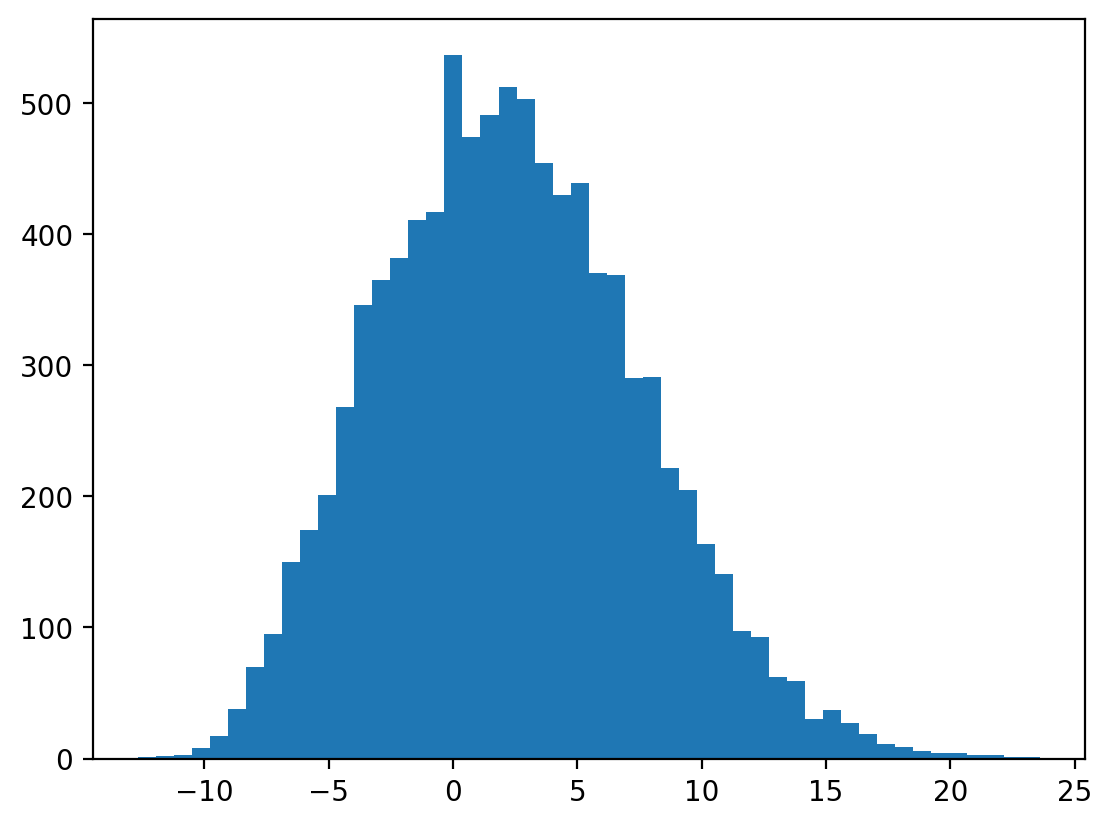

In [870]:
from lifelines import CoxPHFitter

mrdt = 8
duration_col = 'PERMTH_EXM'
event_col = 'MORTSTAT'

df = pd.read_csv(f'/Users/jkember/Documents/nia_health/NHANES/biological_age/data/NHANES_data_{gender}.csv')

df_cox = pd.DataFrame()
df_cox[duration_col] = df[duration_col]
df_cox[event_col] = df[event_col]

df_cox['score'] = deltas.sum(axis=1)

cph = CoxPHFitter().fit(df_cox, duration_col, event_col)
cph.print_summary()

HR_per_unit = cph.summary['exp(coef)'].item()
years_per_unit = (np.log(HR_per_unit) / np.log(2)) * mrdt

df_cox['score'] = df_cox['score'] * years_per_unit

plt.hist(df_cox['score'], 50)
plt.show()


In [871]:
df = pd.read_csv(f'/Users/jkember/Documents/nia_health/NHANES/biological_age/data/NHANES_data_{gender}.csv')

df_delta = pd.DataFrame(delta_age, columns=['delta_age'])
df_delta['delta_age'] = df_cox['score']
df_delta['SEQN_new'] = df['SEQN_new']
df_delta['age'] = df['age']
df_delta['bio_age'] = df_delta['age'] + df_delta['delta_age']
df_delta.to_csv(f'bio_age_scores__{gender}.csv')
